# Exercise X: Common Mistakes and Domain-Relevant Insights

This exercise is designed to help you identify and address common mistakes in machine learning workflows, with a specific focus on issues relevant to neuroscience data. You'll explore two key topics:

1. Cross-Validation and Avoiding Data Leakage
2. Handling Class Imbalance

## Part 1: [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html) and Avoiding [Data Leakage](https://www.kaggle.com/code/alexisbcook/data-leakage)

### **Introduction**
Cross-validation is a powerful technique to evaluate model performance by splitting the data into training and testing sets multiple times. However, improper handling of preprocessing steps can lead to **data leakage**, where information from the test set influences the training process, resulting in overly optimistic performance estimates.

### **Task 1: Identifying Data Leakage**

This exercise demonstrates the proper and improper ways to apply cross-validation in a classification task, focusing on feature selection. You’ll see how performing feature selection on the entire dataset before cross-validation ("the wrong way") can lead to misleadingly optimistic results, and how integrating feature selection within each cross-validation fold ("the correct way") provides a realistic error estimate.

### **Scenario**
- **Number of samples (N):** 50
- **Number of predictors (p):** 5000
- **Number of classes:** 2 (balanced)
- Predictors are **independent** of class labels (no real signal).
- **True error rate of any classifier:** 50%

We will:
1. Simulate the "wrong way": Feature selection on the entire dataset before cross-validation.
2. Simulate the "correct way": Feature selection within each cross-validation fold.

In [27]:
import warnings

warnings.filterwarnings("ignore")

In [37]:
import numpy as np

# Generate synthetic data
N, p, num_predictors, K = 50, 5000, 100, 10
np.random.seed(0)
y = np.array([0] * (N // 2) + [1] * (N // 2))
np.random.shuffle(y)
X = np.random.randn(N, p)

n_simulations = 500

### **Step 1: Simulate the Wrong Way**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier

def simulate_wrong(X:np.ndarray, y:np.ndarray, num_predictors:int, K:int) -> None:
    # Fit a KNN classifier with the wrong number of predictors
    selector_wrong = SelectKBest(score_func=f_classif, k=num_predictors)
    selector_wrong.fit(X, y)
    X_selected_wrong = selector_wrong.transform(X)

    # Initialize cross-validation
    kf = KFold(n_splits=K, shuffle=True, random_state=None)
    errors_wrong = []
    knn_wrong = KNeighborsClassifier(n_neighbors=1)

    for train_index, test_index in kf.split(X_selected_wrong):
        X_train, X_test = X_selected_wrong[train_index], X_selected_wrong[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        knn_wrong.fit(X_train, y_train)

        # Predict on the test set
        y_pred = knn_wrong.predict(X_test)

        # Calculate error rate
        error = np.mean(y_pred != y_test)
        errors_wrong.append(error)

    avg_error_wrong = np.mean(errors_wrong)
    return avg_error_wrong

wrong_estimates = [simulate_wrong(X, y, num_predictors, K) for _ in range(n_simulations)]
print(
    f"Average error rate with the wrong number of predictors: {np.mean(wrong_estimates):.3f} ± {np.std(wrong_estimates):.3f}"
)

Average error rate with the wrong number of predictors: 0.044 ± 0.012


`````{admonition} Question:
* Why does feature selection on the entire dataset before cross-validation lead to an overly optimistic error rate?

````{dropdown} Solution
When feature selection is performed on the entire dataset before cross-validation, the test set indirectly influences the selection of features. This means that information from the test set leaks into the training process, leading to an overfit model that performs unrealistically well during validation. As a result, the estimated error rate is lower than the true error rate because the model has effectively "seen" part of the test data during training.
````
`````

### **Step 2: Simulate the Correct Way**

In [35]:
def simulate_right(X:np.ndarray, y:np.ndarray, num_predictors:int, K:int) -> None:
    # Initialize cross-validation
    errors_correct = []
    kf_correct = KFold(n_splits=K, shuffle=True, random_state=None)

    for train_index, test_index in kf_correct.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Feature selection on the training data only
        selector_correct = SelectKBest(score_func=f_classif, k=num_predictors)
        selector_correct.fit(X_train, y_train)
        X_train_selected = selector_correct.transform(X_train)
        X_test_selected = selector_correct.transform(X_test)

        # Train the classifier
        knn_correct = KNeighborsClassifier(n_neighbors=1)
        knn_correct.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = knn_correct.predict(X_test_selected)

        # Calculate error rate
        error = np.mean(y_pred != y_test)
        errors_correct.append(error)

    avg_error_correct = np.mean(errors_correct)
    return avg_error_correct

right_estimates = [simulate_right(X, y, num_predictors, K) for _ in range(n_simulations)]
print(
    f"Average error rate with the right number of predictors: {np.mean(right_estimates):.3f} ± {np.std(right_estimates):.3f}"
)

Average error rate with the right number of predictors: 0.472 ± 0.055


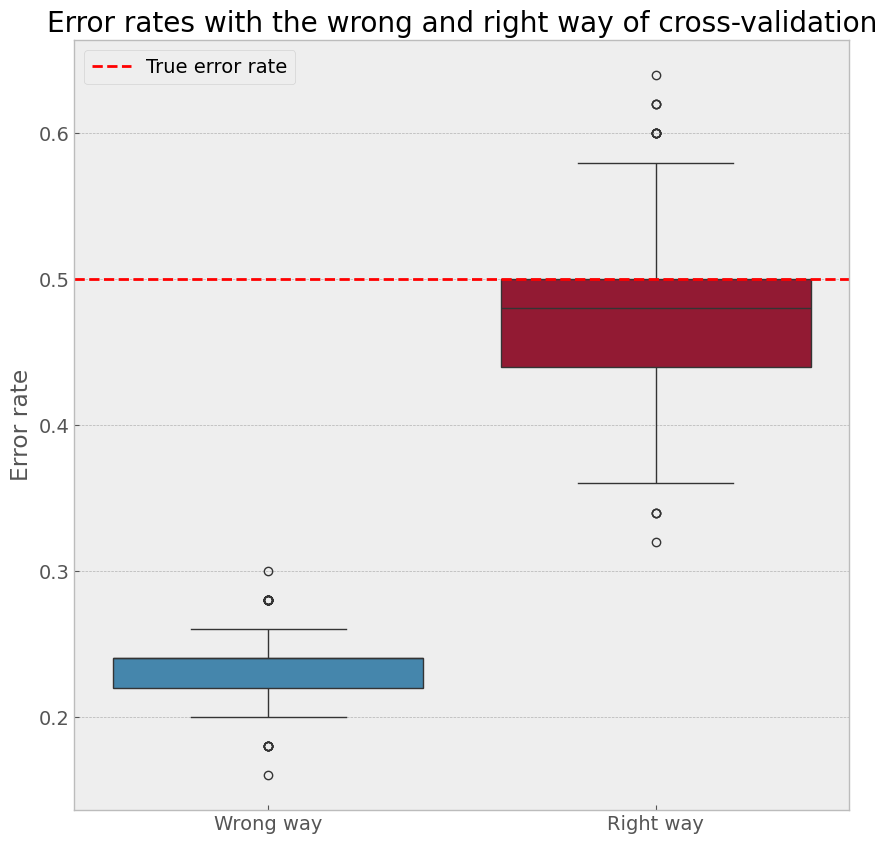

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

plt.rcParams.update({'font.size': 14})
# plot the distribution of error rates and the true error rate
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=[wrong_estimates, right_estimates], ax=ax)
# add a horizontal line for the true error rate
ax.axhline(0.5, color='red', linestyle='--', label='True error rate')
ax.set_xticklabels(["Wrong way", "Right way"])
ax.set_ylabel("Error rate")
ax.set_title("Error rates with the wrong and right way of cross-validation")
plt.legend()
plt.show()


`````{admonition} Question:
* How does performing feature selection within each fold of cross-validation provide a more accurate error estimate?

````{dropdown} Solution
Performing feature selection within each fold ensures that the test set remains completely unseen during the training process. This avoids data leakage, as the feature selection is based solely on the training data within that fold. By doing this, the evaluation provides a realistic estimate of the model's performance on truly unseen data, preventing over-optimistic error rates.

````
`````

## Additional Notes
### The 'Correct Way' often produces error rates higher than the true error rate (e.g., ~60%) in this scenario. This happens because:
1. The predictors are randomly generated and independent of the labels, so selected features correlate with the labels purely by chance.
2. High dimensionality and small sample size lead to overfitting, especially with inconsistent feature sets across folds.
3. The nearest-neighbor classifier is sensitive to noisy or irrelevant features, highlighting this issue.

## To further investigate:
* Inspect the features selected in each fold.
* Reduce the number of predictors (e.g., from 5000 to 500) and observe the results.
* Use a different classifier (e.g., logistic regression) to reduce sensitivity to noise.